<a href="https://colab.research.google.com/github/prueba2001/primera-AI/blob/main/emociones1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1️⃣ Montar tu Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ Definir la ruta del archivo ZIP en tu Drive
# ⚠️ Ajusta la ruta según la ubicación exacta del archivo en tu Drive
zip_path = '/content/drive/MyDrive/vit-finetuned-emotions_1.zip'

# 3️⃣ Definir la carpeta donde quieres descomprimirlo
extract_path = '/content/vit-finetuned-emotions'

# 4️⃣ Descomprimir el archivo
import zipfile
import os

# Crear la carpeta destino si no existe
os.makedirs(extract_path, exist_ok=True)

# Extraer el contenido
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Archivo descomprimido en: {extract_path}")


Mounted at /content/drive
✅ Archivo descomprimido en: /content/vit-finetuned-emotions


In [ ]:
# =================================================================================
# CELDA TODO-EN-UNO: limpia paquetes conflictivos, instala dependencias compatibles,
# y luego ejecuta el entrenamiento ViT (pegalo todo en una sola celda)
# =================================================================================
# --- 1) LIMPIAR (desinstalar versiones que suelen dar conflicto) ---
!pip uninstall -y datasets transformers evaluate fsspec gcsfs accelerate >/dev/null 2>&1 || true

# --- 2) Actualizar pip y luego instalar paquetes sin forzar fsspec/gcsfs ---
!python -m pip install --upgrade pip >/dev/null
!pip install -q --upgrade transformers datasets evaluate accelerate

# --- 3) Mostrar versiones instaladas para verificar (no debería aparecer conflicto) ---
import pkgutil, importlib, sys, subprocess, json
def show_ver(pkg):
    try:
        mod = importlib.import_module(pkg)
        v = getattr(mod, "__version__", "??")
    except Exception:
        v = "no instalado"
    print(f"{pkg:12s} -> {v}")

print("Versiones instaladas:")
for p in ["pip","transformers","datasets","evaluate","accelerate","fsspec","gcsfs"]:
    if p=="pip":
        import pip as _pip
        print(f"pip          -> {_pip.__version__}")
    else:
        show_ver(p)

# =================================================================================
# Si todo ok, continúa con el código de entrenamiento (coloca aquí abajo tu código)
# =================================================================================


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.27.0 requires gcsfs!=2025.5.0,>=2023.3.0, which is not installed.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
Versiones instaladas:
pip          -> 25.3
transformers -> 4.57.1
datasets     -> 4.0.0
evaluate     -> 0.4.6
accelerate   -> 1.11.0
fsspec       -> 2025.3.0
gcsfs        -> no instalado


In [ ]:
# ======================  CODIGO DE ENTRENAMIENTO  ==============================
# (Ejecutar esta parte DESPUÉS de la instalación anterior en la misma celda)
import os
os.environ["WANDB_DISABLED"] = "true"

from datasets import load_dataset, DatasetDict
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
import torch
import evaluate
import numpy as np

# --- RUTAS (las tuyas) ---
train_dir = "/content/dataset/dataset/train"
val_dir   = "/content/dataset/dataset/val"
test_dir  = "/content/dataset/dataset/test"

# --- CARGAR datasets (cada carpeta debe contener subcarpetas por clase) ---
ds_train = load_dataset("imagefolder", data_dir=train_dir, split="train")
ds_val   = load_dataset("imagefolder", data_dir=val_dir,   split="train")
ds_test  = load_dataset("imagefolder", data_dir=test_dir,  split="train")

ds = DatasetDict({"train": ds_train, "val": ds_val, "test": ds_test})
print("Datasets cargados:", ds)
labels = ds_train.features['label'].names
print("Clases encontradas:", labels)
if ds_val.features['label'].names != labels or ds_test.features['label'].names != labels:
    print("Advertencia: las clases difieren entre splits (revisa nombres de carpetas)")

# --- PREPROCESSOR ViT ---
model_name = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_name)

def transformar(batch):
    images = [img.convert("RGB") for img in batch["image"]]
    inputs = processor(images, return_tensors="pt")
    # convertimos a numpy porque datasets con with_transform serializa mejor así
    return {"pixel_values": inputs["pixel_values"].numpy(), "label": batch["label"]}

ds_transf = ds.with_transform(transformar)

# --- DATA COLLATOR ---
def data_collator(batch):
    # batch: lista de dicts con 'pixel_values' (numpy array) y 'label'
    pv = torch.stack([torch.tensor(x["pixel_values"]) for x in batch])
    # si aparece dimensión extra: squeeze
    if pv.dim() == 5 and pv.shape[1] == 1:
        pv = pv.squeeze(1)
    labels_tensor = torch.tensor([x["label"] for x in batch], dtype=torch.long)
    return {"pixel_values": pv, "labels": labels_tensor}

# --- id2label / label2id ---
id2label = {i: c for i, c in enumerate(labels)}
label2id = {c: i for i, c in enumerate(labels)}

# --- Modelo ---
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# --- Métricas ---
acc = evaluate.load("accuracy")
f1 = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, refs = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=refs)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=refs, average="macro")["f1"]
    }

# --- TrainingArguments (ajusta batch si OOM) ---
per_device_train_bs = 8   # si OOM bajar a 4 o 2
per_device_eval_bs = 32

use_cuda = torch.cuda.is_available()
fp16_opt = True if use_cuda else False

training_args = TrainingArguments(
    output_dir="./vit-finetuned-emotions",
    per_device_train_batch_size=per_device_train_bs,
    per_device_eval_batch_size=per_device_eval_bs,
    eval_strategy="steps", # Renamed from evaluation_strategy
    eval_steps=200,
    save_steps=200,
    logging_steps=100,
    num_train_epochs=10,
    learning_rate=5e-6,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    save_total_limit=3,
    fp16=fp16_opt,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=ds_transf["train"],
    eval_dataset=ds_transf["val"],
    tokenizer=processor
)

print("Comenzando entrenamiento. GPU:", use_cuda, " fp16:", fp16_opt)
train_result = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_result.metrics)
trainer.save_metrics("train", train_result.metrics)
trainer.save_state()

metrics_val = trainer.evaluate(eval_dataset=ds_transf["val"])
trainer.log_metrics("eval", metrics_val)
trainer.save_metrics("eval", metrics_val)

metrics_test = trainer.evaluate(eval_dataset=ds_transf["test"])
trainer.log_metrics("test", metrics_test)
trainer.save_metrics("test", metrics_test)

print("Validación:", metrics_val)
print("Test:", metrics_test)
# ================================================================================
# FIN CELDA
# ================================================================================

Resolving data files:   0%|          | 0/22595 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2559 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/5052 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/2879 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/613 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/2797 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/332 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/603 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Datasets cargados: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 22595
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 2879
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2797
    })
})
Clases encontradas: ['angry3', 'contempt3', 'disgust3', 'fear3', 'happy3', 'neutral3', 'sad3', 'surprise3']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3543755366.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Comenzando entrenamiento. GPU: True  fp16: True


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
200,1.905400,1.835263,0.402570,0.269576
400,1.677300,1.574578,0.557833,0.431797
600,1.403000,1.366080,0.623828,0.535403
800,1.247400,1.210349,0.716568,0.662130
1000,1.111100,1.081574,0.783258,0.771500
1200,0.989200,0.971765,0.798541,0.792962
1400,0.933400,0.891661,0.831191,0.833561
1600,0.825800,0.820894,0.833970,0.833860
1800,0.759100,0.752199,0.856547,0.857192
2000,0.699400,0.706583,0.855505,0.858259


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
200,1.905400,1.835263,0.402570,0.269576
400,1.677300,1.574578,0.557833,0.431797
600,1.403000,1.366080,0.623828,0.535403
800,1.247400,1.210349,0.716568,0.662130
1000,1.111100,1.081574,0.783258,0.771500
1200,0.989200,0.971765,0.798541,0.792962
1400,0.933400,0.891661,0.831191,0.833561
1600,0.825800,0.820894,0.833970,0.833860
1800,0.759100,0.752199,0.856547,0.857192
2000,0.699400,0.706583,0.855505,0.858259


***** train metrics *****
  epoch                    =          10.0
  total_flos               = 16307697292GF
  train_loss               =        0.2306
  train_runtime            =    1:20:54.57
  train_samples_per_second =        46.544
  train_steps_per_second   =         5.819


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9243
  eval_f1_macro           =     0.9245
  eval_loss               =     0.3545
  eval_runtime            = 0:00:11.95
  eval_samples_per_second =    240.781
  eval_steps_per_second   =      7.527
***** test metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9235
  eval_f1_macro           =     0.9268
  eval_loss               =     0.3338
  eval_runtime            = 0:00:11.74
  eval_samples_per_second =    238.118
  eval_steps_per_second   =      7.492
Validación: {'eval_loss': 0.3544843792915344, 'eval_accuracy': 0.924279263633206, 'eval_f1_macro': 0.9245053093710288, 'eval_runtime': 11.9569, 'eval_samples_per_second': 240.781, 'eval_steps_per_second': 7.527, 'epoch': 10.0}
Test: {'eval_loss': 0.3338310420513153, 'eval_accuracy': 0.9234894529853415, 'eval_f1_macro': 0.9268268648532222, 'eval_runtime': 11.7463, 'eval_samples_per_second': 238.118, 'e

Dispositivo: cuda
Processor cargado desde ./vit-finetuned-emotions
Arrastra/selecciona la(s) imagen(es) que quieres predecir (Colab Upload)...


Saving Captura desde 2025-11-04 12-50-11.png to Captura desde 2025-11-04 12-50-11.png

==> Prediciendo: Captura desde 2025-11-04 12-50-11.png


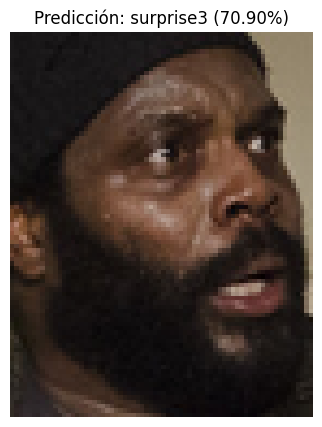

Top-3:
1. surprise3 (id=7) — 70.90%
2. fear3 (id=3) — 21.20%
3. happy3 (id=4) — 2.27%


In [ ]:
# INFERENCIA: cargar modelo guardado, subir imagen y predecir
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTImageProcessor
import numpy as np

# --------- Config ----------
model_dir = "./vit-finetuned-emotions"   # carpeta donde guardaste el modelo con trainer.save_model()
model_name = "google/vit-base-patch16-224-in21k"  # fallback si el processor no está guardado
top_k = 3
# --------------------------

# 1) Cargar modelo
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Dispositivo:", device)
model = ViTForImageClassification.from_pretrained(model_dir)
model.to(device)
model.eval()

# 2) Cargar processor (intenta desde model_dir, si no usa el model_name)
try:
    processor = ViTImageProcessor.from_pretrained(model_dir)
    print("Processor cargado desde", model_dir)
except Exception as e:
    print("No se pudo cargar processor desde", model_dir, " — usando", model_name, "como fallback.")
    processor = ViTImageProcessor.from_pretrained(model_name)

# Helper para obtener label seguro (las keys en id2label a veces son str o int)
def id2label_safe(config, idx):
    mapping = getattr(config, "id2label", None)
    if mapping is None:
        return str(idx)
    # Try both str and int keys
    return mapping.get(str(idx), mapping.get(idx, str(idx)))

# Función de inferencia para una imagen única
def predecir(model, processor, img_path, top_k=3, device=device, show=True):
    # Cargar imagen y convertir a RGB
    image = Image.open(img_path).convert("RGB")

    # Preprocesar (el processor se encarga de resize, crop y normalización)
    inputs = processor(images=[image], return_tensors="pt")
    # mover tensores al device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits  # shape (1, num_labels)
    probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()  # vector de probabilidades

    # top-k
    topk_idx = np.argsort(probs)[::-1][:top_k]
    results = [(int(idx), id2label_safe(model.config, int(idx)), float(probs[int(idx)])) for idx in topk_idx]

    if show:
        # Mostrar imagen y título con la mejor predicción
        best_label = results[0][1]
        best_prob = results[0][2]
        plt.figure(figsize=(5,5))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Predicción: {best_label} ({best_prob*100:.2f}%)")
        plt.show()

        # Mostrar tabla simple de top-k
        print("Top-{}:".format(top_k))
        for i, (idx, label, p) in enumerate(results, 1):
            print(f"{i}. {label} (id={idx}) — {p*100:.2f}%")

    return results

# -----------------------
# Si estás en Colab: subir una imagen y predecir
# -----------------------
try:
    # Sólo funciona en Colab / Jupyter con extensiones apropiadas
    from google.colab import files
    print("Arrastra/selecciona la(s) imagen(es) que quieres predecir (Colab Upload)...")
    uploaded = files.upload()
    for fname in uploaded.keys():
        print("\n==> Prediciendo:", fname)
        predecir(model, processor, "/content/" + fname, top_k=top_k, device=device, show=True)

except Exception:
    # Fallback: si no estás en Colab, usa ruta local
    print("No estás en Colab (o files.upload no disponible). Usa predecir(model, processor, '/ruta/a/tu/imagen.jpg') manualmente.")
    # Ejemplo de uso local:
    # predecir(model, processor, '/content/dataset/val/fractura/0027.jpg', top_k=3)


In [ ]:
# Celda 1 — Comprimir carpeta a ZIP y mostrar tamaño
import os
import shutil

folder = "/content/vit-finetuned-emotions"
output_base = "/content/vit-finetuned-emotions"   # salida: /content/vit-finetuned-emotions.zip
zip_path = output_base + ".zip"

if not os.path.exists(folder):
    raise FileNotFoundError(f"No existe la carpeta: {folder}")

# Eliminar ZIP previo si existe
if os.path.exists(zip_path):
    print("Eliminando ZIP previo:", zip_path)
    os.remove(zip_path)

print("Comprimiendo", folder, "->", zip_path, " (esto puede tardar unos segundos/minutos)...")
shutil.make_archive(output_base, 'zip', folder)
size_bytes = os.path.getsize(zip_path)
size_mb = size_bytes / 1024 / 1024
print(f"ZIP creado: {zip_path}  —  Tamaño: {size_mb:.2f} MB")


Comprimiendo /content/vit-finetuned-emotions -> /content/vit-finetuned-emotions.zip  (esto puede tardar unos segundos/minutos)...
ZIP creado: /content/vit-finetuned-emotions.zip  —  Tamaño: 3023.25 MB


In [ ]:
# Celda 3 — Montar Drive y copiar el ZIP a MyDrive
from google.colab import drive
import shutil
import os

zip_path = "/content/vit-finetuned-emotions.zip"
if not os.path.exists(zip_path):
    raise FileNotFoundError("Ejecuta antes la celda que crea el ZIP.")

drive.mount('/content/drive')   # te pedirá autorización

# Cambia el destino si quieres otra carpeta dentro de tu Drive
dest = "/content/drive/MyDrive/vit-finetuned-emotions.zip"

# Si existe, añadir sufijo para no sobrescribir
if os.path.exists(dest):
    base, ext = os.path.splitext(dest)
    i = 1
    while os.path.exists(f"{base}_{i}{ext}"):
        i += 1
    dest = f"{base}_{i}{ext}"

print("Copiando ZIP a Drive:", dest)
shutil.copy(zip_path, dest)
print("Copia completada. Archivo en tu Google Drive:", dest)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copiando ZIP a Drive: /content/drive/MyDrive/vit-finetuned-emotions_1.zip
Copia completada. Archivo en tu Google Drive: /content/drive/MyDrive/vit-finetuned-emotions_1.zip
